In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, explained_variance_score
from utils_plot import *

In [2]:
def performance_metrics(rates, reconstructed_rates):
    """ Compute MSE between rates and reconstructed rates from model """
    MSE = mean_squared_error(rates, reconstructed_rates)
    EV = explained_variance_score(rates, reconstructed_rates)
    c = np.corrcoef(rates.flatten(), reconstructed_rates.flatten())[0, 1] #Corr coef (Pearson's r)
    return MSE, EV, c

In [3]:
filedeepcycle = "/shared/space2/molina/Data/mESCs_2iLIF/SRR13790993/deepcycle/deepcycle.h5ad"
fileBSM = 'Data/data_binding_site_matrix.txt'
# Generate smooth theta values
theta_smooth = np.linspace(0, 1, 100)

In [4]:
# Reading binding site matrix and targets' rates
N = pd.read_csv(fileBSM, sep="\t",index_col=0)

In [5]:
adata = sc.read_h5ad(filedeepcycle)
adata.var_names_make_unique()
thetas = adata.obs['cell_cycle_theta']
E = adata.layers['Mu'].T
print(E.shape)

(11098, 5683)


/shared/home/suttyg/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
thetas.shape

(5683,)

In [7]:
#PREPROCESSING
#Removal of targets that does not contain any known binding site.
tf_names = N.columns
targetnames_N = N.index
targetnames_E = adata.var_names
targetnames = targetnames_E.intersection(targetnames_N)
E = E[[targetnames_E.get_loc(name) for name in list(targetnames)], :]

# Filtering the arrays
N = N.loc[targetnames].to_numpy()

#N = N - N.mean(axis=0,keepdims=True)
#E = E - E.mean(axis=1,keepdims=True) - E.mean(axis=0,keepdims=True) + E.mean()
print("Kept genes :", E.shape[0])

Kept genes : 8400


#### Ridge

In [8]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=40)
lambda_values = np.logspace(0, 3, 20)
num_BPs = N.shape[1]

# Initialize dictionaries to store MSE for each fold
MSE_train_all = {lmbda: [] for lmbda in lambda_values}
MSE_test_all = {lmbda: [] for lmbda in lambda_values}
EV_train_all = {lmbda: [] for lmbda in lambda_values}
EV_test_all = {lmbda: [] for lmbda in lambda_values}

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(N):
    N_train, N_test = N[train_index], N[test_index]
    E_train, E_test = E[train_index], E[test_index]

    for lambda1 in lambda_values:
        # Train Lasso model
        linear_model = Ridge(alpha=lambda1)
        linear_model.fit(N_train, E_train)

        #A = linear_model.coef_.T  # Extract coefficients

        # Predictions
        R_train = linear_model.predict(N_train)
        R_test = linear_model.predict(N_test)

        # Compute MSE
        MSE_train, EV_train, c_train = performance_metrics(E_train, R_train)
        MSE_test, EV_test, c_test = performance_metrics(E_test, R_test)

        # Store per lambda & fold
        MSE_train_all[lambda1].append(MSE_train)
        MSE_test_all[lambda1].append(MSE_test)
        EV_train_all[lambda1].append(EV_train)
        EV_test_all[lambda1].append(EV_test)
    print("Fold done")

Fold done
Fold done
Fold done
Fold done
Fold done


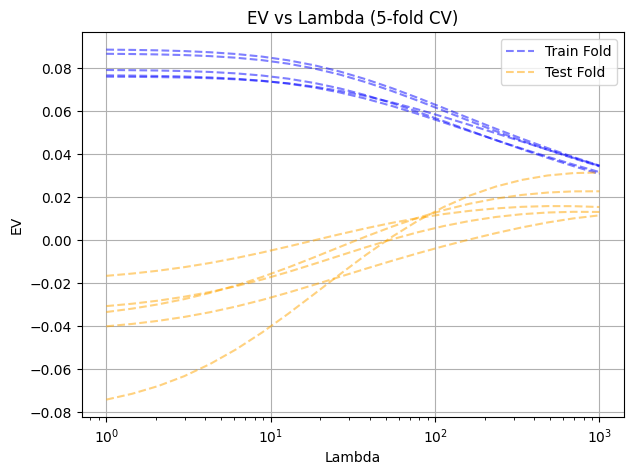

In [9]:
plot_CV_results(lambda_values, EV_train_all, EV_test_all, metrics="EV", plot_mean=False)
#plot_CV_results(lambda_values, MSE_train_all, MSE_test_all, plot_mean=True)

In [10]:
%%!

UsageError: %%! is a cell magic, but the cell body is empty.


#### Bayesian

In [ ]:
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.multioutput import MultiOutputRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store MSE results
MSE_train_all = []
MSE_test_all = []

for train_index, test_index in kf.split(N):
    N_train, N_test = N[train_index], N[test_index]
    E_train, E_test = E[train_index], E[test_index]

    # Wrap the bayesian regressor in a MultiOutputRegressor
    multi_bayesian = MultiOutputRegressor(BayesianRidge())
    multi_bayesian.fit(N_train, E_train)

    # Get coefficient matrix from each output regressor
    A = np.array([reg.coef_.T for reg in multi_bayesian.estimators_])  # Shape (TFs, cells)
    alpha_1 = [estimator.alpha_1 for estimator in multi_bayesian.estimators_]
    alpha_2 = [estimator.alpha_2 for estimator in multi_bayesian.estimators_]
    lambda_1 = [estimator.lambda_1 for estimator in multi_bayesian.estimators_]
    lambda_2 = [estimator.lambda_2 for estimator in multi_bayesian.estimators_]

    # Predict
    R_train = N_train @ A.T  # Transpose to match correct shape
    R_test = N_test @ A.T

    # Compute MSE
    MSE_train, EV_train, c_train = performance_metrics(E_train, R_train)
    MSE_test, EV_test, c_test = performance_metrics(E_test, R_test)
    print(MSE_train, MSE_test)

    # Store results
    MSE_train_all.append(MSE_train)
    MSE_test_all.append(MSE_test)

# Compute average results across folds
MSE_train_mean = np.mean(MSE_train_all)
MSE_test_mean = np.mean(MSE_test_all)

# Print results
print("Bayesian Regression MSE Train Mean:", MSE_train_mean)
print("Bayesian Regression MSE Test Mean:", MSE_test_mean)

Bayesian results : 

MSE_train :  0.1832810793702796 MSE_test :  0.19951647240458137

MSE_train :  0.19179256411170012 MSE_test :  0.16330723773265504

MSE_train :  0.18017141762140668 MSE_test :  0.20820601487740778

MSE_train :  0.18763011838430638 MSE_test :  0.176608645283421

MSE_train :  0.18474606507085847 MSE_test :  0.1918368631437073

Bayesian Regression MSE Train Mean: 0.1855242489117102

Bayesian Regression MSE Test Mean: 0.1878950466883545